In [1]:
import logging
import time
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
from pyspark import SparkConf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StructType, StructField, LongType, StringType, ArrayType
from graphframes import GraphFrame

# --- Initialize Logger ---
# Set up basic logging (adjust level and format as needed)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Spark Configuration (assuming you have this configured from previous steps) ---
conf = SparkConf() \
    .setAppName("SARL_Spark_LPA_Partitioning") \
    .setMaster("local[*]") \
    .set("spark.driver.memory", "24g") \
    .set("spark.executor.memory", "24g") \
    .set("spark.executor.instances", "6") \
    .set("spark.executor.cores", "6") \
    .set("spark.memory.offHeap.enabled", "true") \
    .set("spark.memory.offHeap.size", "3g") \
    .set("spark.sql.shuffle.partitions", "200") \
    .set("spark.executor.extraJavaOptions", "-Xss4m") \
    .set("spark.driver.extraJavaOptions", "-Xss4m") \
    .set("spark.executor.memoryOverhead", "8g") \
    .set("spark.driver.memoryOverhead", "8g") \
    .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .set("spark.kryoserializer.buffer.max", "512m") \
    .set("spark.memory.fraction", "0.6") \
    .set("spark.memory.storageFraction", "0.5") \
    .set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext # Get SparkContext for log level setting
sc.setLogLevel("INFO") # Set Spark's own logging level
logger.info(f"Spark Version: {spark.version}")
logger.info(f"Spark Driver Memory: {spark.conf.get('spark.driver.memory')}")
logger.info(f"Spark Executor Memory: {spark.conf.get('spark.executor.memory')}")
logger.info(f"Spark Executor Cores: {spark.conf.get('spark.executor.cores')}")

2025-06-03 16:27:14,181 - INFO - Spark Version: 3.4.0
2025-06-03 16:27:14,569 - INFO - Spark Driver Memory: 24g
2025-06-03 16:27:14,570 - INFO - Spark Executor Memory: 24g
2025-06-03 16:27:14,570 - INFO - Spark Executor Cores: 6


In [2]:
# --- Step 0: Load and Preprocess Data (Optimized) ---
logger.info("Step 0: Loading and Preprocessing Data (Optimized)...")
start_time = time.time()

transaction_file_path = 'sarl-spark/data/processed/transactional_data_zscore.csv'

# Load the raw text file into an RDD
raw_lines_rdd = sc.textFile(transaction_file_path)

# Get the header row. This action will cause Spark to read the first line.
header = raw_lines_rdd.first()
# Filter out the header row from the RDD, then proceed with mapping and filtering
transactions_rdd = raw_lines_rdd.filter(lambda line: line != header) \
                                 .map(lambda line: [item.strip() for item in line.strip().split(',') if item.strip()]) \
                                 .filter(lambda transaction: len(transaction) > 0)

# Convert to DataFrame
transactions_df = spark.createDataFrame(transactions_rdd, ArrayType(StringType()))
transactions_df = transactions_df.withColumnRenamed("value", "items").filter(F.size("items") < 1000) # Renames the default column 'value' to 'items'
transactions_df.cache()
transactions_df.show(5, truncate=False) # Keep this for initial data check
logger.info(f"Total transactions loaded (after removing header): {transactions_df.count()}")
logger.info(f"Total transactions after removing transactions with more than 1000 items: {transactions_df.count()}")

logger.info(f"Time taken for data loading and preprocessing: {time.time() - start_time:.2f} seconds")

2025-06-03 16:27:14,578 - INFO - Step 0: Loading and Preprocessing Data (Optimized)...
2025-06-03 16:27:15,625 - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-06-03 16:27:15,626 - INFO - NumExpr defaulting to 8 threads.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2025-06-03 16:27:18,909 - INFO - Total transactions loaded (after removing header): 1570
2025-06-03 16:27:18,997 - INFO - Total transactions after removing transactions with more than 1000 items: 1570
2025-06-03 16:27:18,997 - INFO - Time taken for data loading and preprocessing: 4.42 seconds


Total number of transactions: 1570


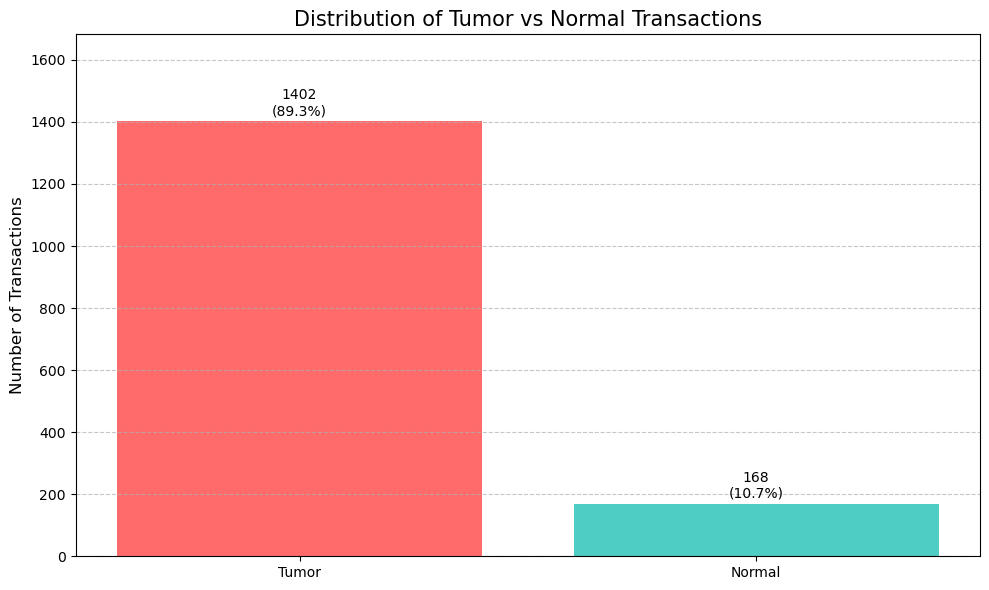

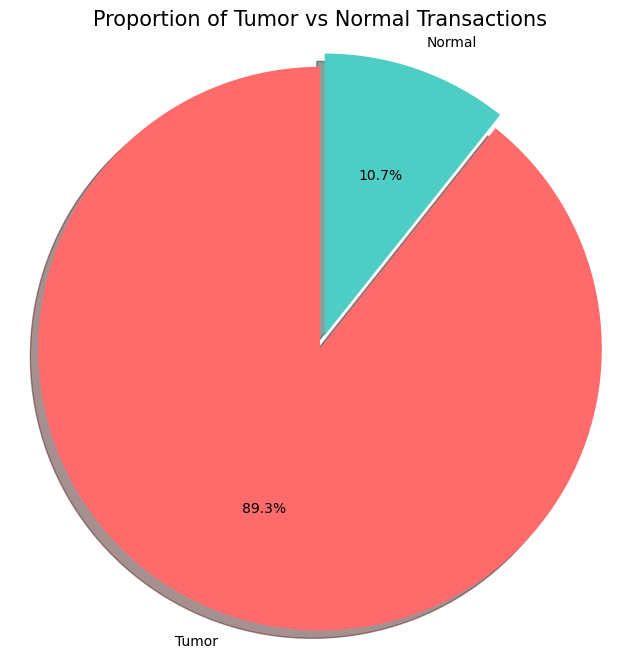

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get counts directly from the data
tumor_count = transactions_df.filter(
    F.array_contains(F.col("items"), "tumor")
).count()

normal_count = transactions_df.filter(
    F.array_contains(F.col("items"), "normal")
).count()

# Data
categories = ['Tumor', 'Normal']
counts = [tumor_count, normal_count]

# Calculate total transactions
total_transactions = transactions_df.count()
print(f"Total number of transactions: {total_transactions}")

# Create figure
plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(categories, counts, color=['#FF6B6B', '#4ECDC4'])

# Add count and percentage labels on top of bars
for bar, count in zip(bars, counts):
    percentage = (count / total_transactions) * 100
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 20,
        f'{count}\n({percentage:.1f}%)',
        ha='center'
    )

# Add title and labels
plt.title('Distribution of Tumor vs Normal Transactions', fontsize=15)
plt.ylabel('Number of Transactions', fontsize=12)
plt.ylim(0, max(counts) * 1.2)  # Add some space for the labels

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Pie chart for proportion
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=categories,
    autopct='%1.1f%%',
    colors=['#FF6B6B', '#4ECDC4'],
    explode=(0.05, 0),  # Slightly explode the tumor slice
    shadow=True,
    startangle=90
)
plt.title('Proportion of Tumor vs Normal Transactions', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [4]:
# --- SARL Heuristic Parameters ---
MIN_SUPPORT_PERCENTAGE = 0.03
NUM_PARTITIONS_K = 100
MIN_CONFIDENCE = 0.7

# Calculate actual min_support count for filtering 1- and 2-itemsets
total_transactions = transactions_df.count()
min_support_count = int(total_transactions * MIN_SUPPORT_PERCENTAGE)
min_support_fraction = MIN_SUPPORT_PERCENTAGE # FPGrowth expects a fraction

logger.info(f"SARL Parameters: min_support_percentage={MIN_SUPPORT_PERCENTAGE}, num_partitions_k={NUM_PARTITIONS_K}, min_confidence={MIN_CONFIDENCE}")
logger.info(f"Calculated min_support_count: {min_support_count}")

# --- Step 1: Find Frequent One-Itemsets ---
logger.info("Step 1: Finding Frequent One-Itemsets...")
start_time = time.time()

# Explode the 'items' array to get individual items, then group by item and count their occurrences.
frequent_1_itemsets_df = transactions_df.select(F.explode("items").alias("item")) \
                                        .groupBy("item") \
                                        .count() \
                                        .filter(F.col("count") >= min_support_count) \
                                        .withColumn("items", F.array(F.col("item"))) \
                                        .select("items", "count")
frequent_1_itemsets_df.cache() # Cache for later use
logger.info(f"Found {frequent_1_itemsets_df.count()} frequent 1-itemsets.")
frequent_1_itemsets_df.orderBy("count", ascending=False).show(5, truncate=False)
logger.info(f"Time taken for Step 1: {time.time() - start_time:.2f} seconds")

2025-06-03 16:27:19,917 - INFO - SARL Parameters: min_support_percentage=0.03, num_partitions_k=100, min_confidence=0.7
2025-06-03 16:27:19,917 - INFO - Calculated min_support_count: 47
2025-06-03 16:27:19,918 - INFO - Step 1: Finding Frequent One-Itemsets...
2025-06-03 16:27:21,212 - INFO - Found 2713 frequent 1-itemsets.
2025-06-03 16:27:21,673 - INFO - Time taken for Step 1: 1.76 seconds


+----------+-----+
|items     |count|
+----------+-----+
|[tumor]   |1402 |
|[normal]  |168  |
|[+UGT2B28]|118  |
|[+SLC26A3]|117  |
|[+NXPH1]  |114  |
+----------+-----+
only showing top 5 rows



In [5]:
# --- Step 2: Find Frequent Two-Itemsets and Prepare IAG Edges ---
logger.info("Step 2: Finding Frequent Two-Itemsets and Preparing IAG Edges...")
start_time = time.time()

# Define cache path for frequent 2-itemsets
cache_dir = "tmp/spark-cache"
frequent_2_itemsets_cache_path = f"{cache_dir}/frequent_2_itemsets_{min_support_fraction}"

# Check if cached result exists with the same min_support
import os
cached_result_exists = False

try:
    # Try to access the cache metadata file that stores the min_support value
    metadata_path = f"{frequent_2_itemsets_cache_path}/_metadata"
    cached_result_exists = os.path.exists(metadata_path)

    if cached_result_exists:
        logger.info(f"Found cached frequent 2-itemsets with min_support={min_support_fraction}")
        # Load from cache
        frequent_2_itemsets_df = spark.read.parquet(frequent_2_itemsets_cache_path)
        frequent_2_itemsets_df.cache()  # Cache in memory for faster access
        logger.info(f"Loaded {frequent_2_itemsets_df.count()} frequent 2-itemsets from cache.")
        frequent_2_itemsets_df.show(5, truncate=False)
except Exception as e:
    logger.warning(f"Error checking or loading cache: {str(e)}")
    cached_result_exists = False

# If no cached result, compute the frequent 2-itemsets
if not cached_result_exists:
    logger.info("Computing frequent 2-itemsets (no cache found or cache invalid)...")

    # Create a DataFrame with individual items and their transaction IDs
    item_df = transactions_df.withColumn(
        "transaction_id", F.monotonically_increasing_id()
    ).select(
        F.col("transaction_id"),
        F.explode("items").alias("item")
    )
    item_df.cache()  # Cache item_df as it's used in the join

    # Self-join to create pairs (more efficient than UDF)
    pairs_df = item_df.alias("a").join(
        item_df.alias("b"),
        (F.col("a.transaction_id") == F.col("b.transaction_id")) &
        (F.col("a.item") < F.col("b.item"))  # Ensures unique pairs and consistent order
    ).select(
        F.col("a.item").alias("src"),
        F.col("b.item").alias("dst")
    )

    # Count frequencies and filter by min_support
    frequent_2_itemsets_df = pairs_df.groupBy("src", "dst") \
        .count() \
        .filter(F.col("count") >= min_support_count) \
        .withColumnRenamed("count", "weight")  # Rename count to weight for IAG

    # Save to cache
    try:
        # Ensure directory exists
        os.makedirs(cache_dir, exist_ok=True)

        # Save the DataFrame to disk
        logger.info(f"Saving frequent 2-itemsets to cache: {frequent_2_itemsets_cache_path}")
        frequent_2_itemsets_df.write.mode("overwrite").parquet(frequent_2_itemsets_cache_path)

        # Also save min_support as a small text file for future reference
        with open(f"{cache_dir}/frequent_2_itemsets_{min_support_fraction}_params.txt", "w") as f:
            f.write(f"min_support_fraction={min_support_fraction}\n")
            f.write(f"min_support_count={min_support_count}\n")
            f.write(f"timestamp={time.time()}\n")
    except Exception as e:
        logger.warning(f"Error saving cache: {str(e)}")

    # Clean up
    item_df.unpersist()

    # Cache in memory for later use
    frequent_2_itemsets_df.cache()
    logger.info(f"Found {frequent_2_itemsets_df.count()} frequent 2-itemsets (IAG edges).")
    frequent_2_itemsets_df.show(5, truncate=False)

logger.info(f"Time taken for Step 2: {time.time() - start_time:.2f} seconds")

2025-06-03 16:27:21,683 - INFO - Step 2: Finding Frequent Two-Itemsets and Preparing IAG Edges...
2025-06-03 16:27:21,684 - INFO - Computing frequent 2-itemsets (no cache found or cache invalid)...
2025-06-03 16:27:21,769 - INFO - Saving frequent 2-itemsets to cache: tmp/spark-cache/frequent_2_itemsets_0.03
2025-06-03 16:30:36,483 - INFO - Found 2372 frequent 2-itemsets (IAG edges).
2025-06-03 16:30:36,543 - INFO - Time taken for Step 2: 194.86 seconds


+---------+-----+------+
|src      |dst  |weight|
+---------+-----+------+
|+SAMD13  |tumor|67    |
|+HIST1H1T|tumor|69    |
|+ANPEP   |tumor|82    |
|+PHF12   |tumor|57    |
|+ZNF649  |tumor|61    |
+---------+-----+------+
only showing top 5 rows



In [6]:
# Check if any rows have dst = "normal"
normal_dst_count = frequent_2_itemsets_df.filter(F.col("dst") == "normal").count()

print(f"Number of 2-itemsets with dst = 'normal': {normal_dst_count}")

# If you want to see these rows
if normal_dst_count > 0:
    print("Examples of 2-itemsets with dst = 'normal':")
    frequent_2_itemsets_df.filter(F.col("dst") == "normal").show(10, truncate=False)
else:
    print("No 2-itemsets found with dst = 'normal'")

# You might also want to check for src = "normal"
normal_src_count = frequent_2_itemsets_df.filter(F.col("src") == "normal").count()
print(f"Number of 2-itemsets with src = 'normal': {normal_src_count}")

# Check for either src or dst being "normal"
normal_either_count = frequent_2_itemsets_df.filter(
    (F.col("src") == "normal") | (F.col("dst") == "normal")
).count()
print(f"Number of 2-itemsets with either src or dst = 'normal': {normal_either_count}")

Number of 2-itemsets with dst = 'normal': 0
No 2-itemsets found with dst = 'normal'
Number of 2-itemsets with src = 'normal': 0
Number of 2-itemsets with either src or dst = 'normal': 0


In [7]:
# --- Step 3: Construct IAG and Partition using Label Propagation Algorithm (LPA) ---
logger.info("Step 3: Constructing IAG and Partitioning using LPA...")
start_time = time.time()

# Define cache path for LPA results
cache_dir = "tmp/spark-cache"
lpa_result_cache_path = f"{cache_dir}/lpa_result_{min_support_fraction}"

# Check if cached result exists with the same min_support
import os
cached_lpa_exists = False

try:
    # Try to access the cache metadata file
    metadata_path = f"{lpa_result_cache_path}/_metadata"
    cached_lpa_exists = os.path.exists(metadata_path)

    if cached_lpa_exists:
        logger.info(f"Found cached LPA results with min_support={min_support_fraction}")
        # Load from cache
        lpa_result = spark.read.parquet(lpa_result_cache_path)
        lpa_result.cache()  # Cache in memory for faster access

        # Get the number of actual partitions found by LPA
        num_actual_partitions = lpa_result.select("label").distinct().count()
        logger.info(f"Loaded LPA results with {num_actual_partitions} communities from cache.")
        lpa_result.show(5)
except Exception as e:
    logger.warning(f"Error checking or loading LPA cache: {str(e)}")
    cached_lpa_exists = False

# If no cached result, compute the LPA partitioning
if not cached_lpa_exists:
    logger.info("Computing LPA partitioning (no cache found or cache invalid)...")

    # Create vertices DataFrame for GraphFrames. 'id' column is mandatory.
    # All unique items found in frequent 1-itemsets are considered vertices.
    unique_items_df = frequent_1_itemsets_df.select(F.col("items")[0].alias("id")).distinct()
    unique_items_df.cache()
    logger.info(f"Found {unique_items_df.count()} unique items for IAG vertices.")
    unique_items_df.show(5)

    # Create GraphFrame object.
    # The 'weight' column in edges_df (frequent_2_itemsets_df) will be used by LPA to influence propagation.
    try:
        iag_graph = GraphFrame(unique_items_df, frequent_2_itemsets_df)
        iag_graph.cache() # Cache the GraphFrame for performance
        logger.info(f"IAG created with {iag_graph.vertices.count()} vertices and {iag_graph.edges.count()} edges.")

        # Check graph density to decide on partitioning approach
        vertex_count = iag_graph.vertices.count()
        edge_count = iag_graph.edges.count()
        graph_density = (2.0 * edge_count) / (vertex_count * (vertex_count - 1)) if vertex_count > 1 else 0
        logger.info(f"Graph density: {graph_density:.8f}")

        # If graph is very sparse, use connected components instead of LPA
        if graph_density < 0.0001:  # Threshold can be adjusted
            logger.info("Graph is very sparse. Using connected components instead of LPA.")
            connected_result = iag_graph.connectedComponents()
            connected_result.cache()

            # Count components and their sizes
            component_sizes = connected_result.groupBy("component").count().orderBy("count", ascending=False)
            component_count = component_sizes.count()
            logger.info(f"Found {component_count} connected components")

            # Show the largest components
            logger.info("Largest connected components:")
            component_sizes.show(10)

            # If there are too many tiny components, merge small ones
            if component_count > 100:  # Threshold can be adjusted
                logger.info("Too many small components. Merging small components...")

                # Identify components to keep separate (larger ones)
                large_components = component_sizes.filter(F.col("count") >= 3).select("component").collect()
                large_component_ids = [row.component for row in large_components]

                # Assign a new label: either keep original component or assign to "small_component"
                lpa_result = connected_result.withColumn(
                    "label",
                    F.when(F.col("component").isin(large_component_ids), F.col("component"))
                     .otherwise(F.lit("small_components"))
                )
            else:
                # Just rename the column for consistency
                lpa_result = connected_result.withColumnRenamed("component", "label")
        else:
            # Use Label Propagation Algorithm for denser graphs
            logger.info("Using Label Propagation Algorithm...")
            lpa_result = iag_graph.labelPropagation(maxIter=10)
            lpa_result.cache()

        logger.info("Partitioning completed. Showing first 5 items with their assigned labels:")
        lpa_result.show(5)

        # Get the number of actual partitions found
        num_actual_partitions = lpa_result.select("label").distinct().count()
        logger.info(f"Found {num_actual_partitions} partitions.")

        # Show partition distribution
        logger.info("Partition size distribution:")
        lpa_result.groupBy("label").count().orderBy("count", ascending=False).show(10)

        # Save to cache
        try:
            # Ensure directory exists
            os.makedirs(cache_dir, exist_ok=True)

            # Save the DataFrame to disk
            logger.info(f"Saving partitioning results to cache: {lpa_result_cache_path}")
            lpa_result.write.mode("overwrite").parquet(lpa_result_cache_path)

            # Also save parameters as a small text file for future reference
            with open(f"{cache_dir}/lpa_result_{min_support_fraction}_params.txt", "w") as f:
                f.write(f"min_support_fraction={min_support_fraction}\n")
                f.write(f"min_support_count={min_support_count}\n")
                f.write(f"timestamp={time.time()}\n")
        except Exception as e:
            logger.warning(f"Error saving cache: {str(e)}")

        # Clean up
        iag_graph.unpersist()
        unique_items_df.unpersist()

    except Exception as e:
        logger.error(f"Error during graph partitioning: {e}. Ensure GraphFrames is correctly installed and Spark is configured for it.")
        # In a production environment, you might implement a fallback strategy or exit.
        # For this example, we'll create an empty lpa_result to avoid further errors.
        lpa_result = None
        num_actual_partitions = 0
else:
    # If we loaded from cache, we don't need to create these
    unique_items_df = None
    iag_graph = None

logger.info(f"Time taken for Step 3: {time.time() - start_time:.2f} seconds")

2025-06-03 16:30:37,426 - INFO - Step 3: Constructing IAG and Partitioning using LPA...
2025-06-03 16:30:37,428 - INFO - Computing LPA partitioning (no cache found or cache invalid)...
2025-06-03 16:30:38,135 - INFO - Found 2713 unique items for IAG vertices.
/usr/local/spark/python/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+--------+
|      id|
+--------+
| +SLC2A5|
| +RNF150|
|  +CCL28|
|+FAM186A|
|  +NSRP1|
+--------+
only showing top 5 rows



2025-06-03 16:30:38,624 - INFO - IAG created with 2713 vertices and 2372 edges.
2025-06-03 16:30:39,026 - INFO - Graph density: 0.00064477
2025-06-03 16:30:39,026 - INFO - Using Label Propagation Algorithm...
/usr/local/spark/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
2025-06-03 16:32:13,911 - INFO - Partitioning completed. Showing first 5 items with their assigned labels:


+----------+------------+
|        id|       label|
+----------+------------+
| +KIAA0196|609885356039|
|+HIST1H2BC|609885356039|
|   +AMICA1|609885356039|
|     +UTS2|463856467978|
|    +DPP10|609885356039|
+----------+------------+
only showing top 5 rows



2025-06-03 16:32:15,212 - INFO - Found 531 partitions.
2025-06-03 16:32:15,212 - INFO - Partition size distribution:
2025-06-03 16:32:15,724 - INFO - Saving partitioning results to cache: tmp/spark-cache/lpa_result_0.03


+-------------+-----+
|        label|count|
+-------------+-----+
| 609885356039| 2144|
| 377957122059|   18|
|1073741824004|   12|
|1382979469319|    8|
| 274877906948|    3|
| 833223655434|    2|
| 747324309513|    2|
| 463856467978|    1|
|1013612281857|    1|
|1039382085640|    1|
+-------------+-----+
only showing top 10 rows



2025-06-03 16:32:16,722 - INFO - Time taken for Step 3: 99.30 seconds


In [8]:
# --- Step 4: Partitioning Transactional Dataset (Optimized & Corrected) ---
logger.info("Step 4: Partitioning Transactional Dataset (Optimized & Corrected)...")
start_time = time.time()

if lpa_result is not None and num_actual_partitions > 0:
    # Create a DataFrame with item-to-partition mapping
    item_partition_mapping = lpa_result.select(
        F.col("id").alias("item"),
        F.col("label").alias("partition_id")
    )

    # Add a unique ID to each original transaction - use the same ID generation
    transactions_with_id_df = transactions_df.withColumn(
        "original_transaction_id",
        F.monotonically_increasing_id()
    )

    # Explode the items in each transaction
    exploded_items = transactions_with_id_df.select(
        F.col("original_transaction_id"),
        F.explode("items").alias("item")
    )

    # Join with partition mapping to get partition for each item
    items_with_partitions = exploded_items.join(
        F.broadcast(item_partition_mapping),
        "item",
        "inner"  # Only keep items that have a partition
    )

    # Convert partition_id to string to match original format
    items_with_partitions = items_with_partitions.withColumn(
        "partition_id",
        F.col("partition_id").cast("string")
    )

    # Group by transaction and partition to rebuild sub-transactions
    grouped_items = items_with_partitions.groupBy(
        "original_transaction_id",
        "partition_id"
    ).agg(
        F.collect_list("item").alias("items_unsorted")
    )

    # Sort items within each partition for consistency
    grouped_items_sorted = grouped_items.withColumn(
        "items",
        F.array_sort("items_unsorted")
    ).drop("items_unsorted")

    # Filter sub-transactions with at least 3 items
    partitioned_transactions_df = grouped_items_sorted.filter(
        F.size("items") >= 3
    )

    # Cache for repeated access
    partitioned_transactions_df.cache()

    # Count and show results
    sub_transaction_count = partitioned_transactions_df.count()
    logger.info(f"Total partitioned sub-transactions (for k>=3 mining): {sub_transaction_count}")
    partitioned_transactions_df.show(5, truncate=False)
else:
    # Create empty DataFrame if no partitions
    partitioned_transactions_df = spark.createDataFrame([], StructType([
        StructField("original_transaction_id", LongType(), True),
        StructField("partition_id", StringType(), True),
        StructField("items", ArrayType(StringType()), True)
    ]))
    logger.warning("LPA result not available or no partitions found. Skipping transaction partitioning.")

logger.info(f"Time taken for Step 4: {time.time() - start_time:.2f} seconds")

2025-06-03 16:32:16,732 - INFO - Step 4: Partitioning Transactional Dataset (Optimized & Corrected)...
2025-06-03 16:32:18,302 - INFO - Total partitioned sub-transactions (for k>=3 mining): 1972
2025-06-03 16:32:18,386 - INFO - Time taken for Step 4: 1.65 seconds


+-----------------------+-------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|orig

In [9]:
# --- Step 5: Call FPGrowth on each Transaction Partition (for k >= 3 itemsets) ---
logger.info("Step 5: Mining Frequent Itemsets (k>=3) on each Partition using FPGrowth...")
start_time = time.time()
min_support_fraction = 0.03;

all_frequent_k_plus_itemsets_dfs = [] # List to hold DataFrames of frequent itemsets from each partition

if partitioned_transactions_df.count() > 0:
    # Get unique partition IDs to iterate through.
    partition_ids = [row.partition_id for row in partitioned_transactions_df.select("partition_id").distinct().collect()]
    logger.info(f"Processing {len(partition_ids)} unique partitions.")

    for p_id in partition_ids:
        logger.info(f"  Mining frequent itemsets for partition: {p_id}")
        # Filter the main partitioned DataFrame to get data for the current partition.
        partition_df = partitioned_transactions_df.filter(F.col("partition_id") == p_id)

        # Ensure the partition has enough data to run FPGrowth.
        if partition_df.count() > 0:
            # Initialize FPGrowth. minSupport is the fraction.
            # numPartitions here can be set to 1 or higher, depending on how you want
            # Spark to parallelize within this specific partition's data.
            fpGrowth = FPGrowth(itemsCol="items", minSupport=min_support_fraction, numPartitions=NUM_PARTITIONS_K)

            try:
                model = fpGrowth.fit(partition_df)
                # Filter for itemsets with length >= 3, as 1- and 2-itemsets were handled globally.
                frequent_k_plus_itemsets_for_partition = model.freqItemsets \
                                                                .filter(F.size("items") >= 3) \
                                                                .withColumn("partition_id", F.lit(p_id)) # Add partition ID for tracking

                if frequent_k_plus_itemsets_for_partition.count() > 0:
                    all_frequent_k_plus_itemsets_dfs.append(frequent_k_plus_itemsets_for_partition)
                    logger.info(f"    Found {frequent_k_plus_itemsets_for_partition.count()} frequent itemsets (k>=3) in partition {p_id}.")
                else:
                    logger.info(f"    No frequent itemsets (k>=3) found in partition {p_id}.")
            except Exception as e:
                logger.error(f"Error running FPGrowth on partition {p_id}: {e}")
        else:
            logger.info(f"  Partition {p_id} is empty after filtering for k>=3 items. Skipping FPGrowth.")

    # Union all results from partitions if any were found.
    if all_frequent_k_plus_itemsets_dfs:
        final_frequent_k_plus_itemsets_df = all_frequent_k_plus_itemsets_dfs[0]
        for i in range(1, len(all_frequent_k_plus_itemsets_dfs)):
            final_frequent_k_plus_itemsets_df = final_frequent_k_plus_itemsets_df.union(all_frequent_k_plus_itemsets_dfs[i])
        final_frequent_k_plus_itemsets_df.cache()
        logger.info(f"Total frequent itemsets (k>=3) found across all partitions: {final_frequent_k_plus_itemsets_df.count()}")
        final_frequent_k_plus_itemsets_df.show(5, truncate=False)
    else:
        logger.info("No frequent itemsets (k>=3) found in any partition.")
        final_frequent_k_plus_itemsets_df = spark.createDataFrame([], StructType([
            StructField("items", ArrayType(StringType()), True),
            StructField("freq", LongType(), True),
            StructField("partition_id", StringType(), True)
        ]))
else:
    logger.info("No partitioned transactions available for k>=3 mining.")
    final_frequent_k_plus_itemsets_df = spark.createDataFrame([], StructType([
        StructField("items", ArrayType(StringType()), True),
        StructField("freq", LongType(), True),
        StructField("partition_id", StringType(), True)
    ]))

logger.info(f"Time taken for Step 5: {time.time() - start_time:.2f} seconds")

2025-06-03 16:32:18,397 - INFO - Step 5: Mining Frequent Itemsets (k>=3) on each Partition using FPGrowth...
2025-06-03 16:32:19,070 - INFO - Processing 5 unique partitions.
2025-06-03 16:32:19,070 - INFO -   Mining frequent itemsets for partition: 1073741824004
2025-06-03 16:32:20,755 - INFO -     Found 4017 frequent itemsets (k>=3) in partition 1073741824004.
2025-06-03 16:32:20,756 - INFO -   Mining frequent itemsets for partition: 1382979469319
2025-06-03 16:32:22,295 - INFO -     Found 219 frequent itemsets (k>=3) in partition 1382979469319.
2025-06-03 16:32:22,296 - INFO -   Mining frequent itemsets for partition: 274877906948
2025-06-03 16:32:23,703 - INFO -     Found 1 frequent itemsets (k>=3) in partition 274877906948.
2025-06-03 16:32:23,703 - INFO -   Mining frequent itemsets for partition: 609885356039
2025-06-03 16:32:52,389 - INFO -     No frequent itemsets (k>=3) found in partition 609885356039.
2025-06-03 16:32:52,390 - INFO -   Mining frequent itemsets for partition: 3

+-------------------------------+----+-------------+
|items                          |freq|partition_id |
+-------------------------------+----+-------------+
|[+GRB7, +PGAP3, +STARD3]       |58  |1073741824004|
|[+MED1, +GRB7, +PGAP3]         |38  |1073741824004|
|[+MED1, +GRB7, +PGAP3, +STARD3]|31  |1073741824004|
|[+MED1, +GRB7, +STARD3]        |39  |1073741824004|
|[+MED1, +PGAP3, +STARD3]       |43  |1073741824004|
+-------------------------------+----+-------------+
only showing top 5 rows



In [12]:
from pyspark.storagelevel import StorageLevel
# --- Step 6: Optimized Union of All Frequent Itemsets ---
logger.info("Step 6: Uniting All Frequent Itemsets (Optimized)...")
start_time = time.time()

# First, let's check the sizes of our datasets
f1_count = frequent_1_itemsets_df.count()
f2_count = frequent_2_itemsets_df.count()
fk_count = final_frequent_k_plus_itemsets_df.count()

logger.info(f"Itemset counts - 1-itemsets: {f1_count}, 2-itemsets: {f2_count}, k>=3 itemsets: {fk_count}")
total_count = f1_count + f2_count + fk_count
logger.info(f"Total itemsets before union: {total_count}")

# Standardize schemas separately
frequent_1_itemsets_standard_schema = frequent_1_itemsets_df.select(
    F.col("items"),
    F.col("count").alias("freq")
)

frequent_2_itemsets_standard_schema = frequent_2_itemsets_df \
    .withColumn("items", F.array(F.col("src"), F.col("dst"))) \
    .withColumn("freq", F.col("weight")) \
    .select("items", "freq")

final_frequent_k_plus_itemsets_standard_schema = final_frequent_k_plus_itemsets_df.select(
    F.col("items"),
    F.col("freq")
)

# Use SQL for union and aggregation for better memory management and optimization
# This path is always taken, as it's generally more robust for unions and aggregations.
logger.info("Using SQL for union and aggregation.")

# Create temporary tables for each dataset
frequent_1_itemsets_standard_schema.createOrReplaceTempView("freq_1_itemsets")
frequent_2_itemsets_standard_schema.createOrReplaceTempView("freq_2_itemsets")
final_frequent_k_plus_itemsets_standard_schema.createOrReplaceTempView("freq_k_itemsets") # Use the standardized k_plus DF

# Use SQL to union and aggregate
all_frequent_itemsets_df = spark.sql("""
SELECT items, SUM(freq) as freq
FROM (
    SELECT items, freq FROM freq_1_itemsets
    UNION ALL
    SELECT items, freq FROM freq_2_itemsets
    UNION ALL
    SELECT items, freq FROM freq_k_itemsets
) all_itemsets
GROUP BY items
""")

# Repartition to optimize storage and subsequent operations (like Step 7's collect)
# Adjust num_partitions based on your cluster and expected data size
# A common heuristic is to aim for 128MB-256MB per partition
# For example, if each itemset is ~1KB, 50000 itemsets is 50MB. So 1M itemsets is 1GB.
# If total_count is 1M, aiming for 200 partitions means ~5000 itemsets/partition.
# FIX: Cast spark.conf.get() result to int before comparison
num_partitions_for_final_df = max(int(spark.conf.get("spark.sql.shuffle.partitions")), total_count // 50000)
logger.info(f"Repartitioning final itemsets to {num_partitions_for_final_df} partitions.")
all_frequent_itemsets_df = all_frequent_itemsets_df.repartition(num_partitions_for_final_df)


# Cache with appropriate storage level for subsequent steps
all_frequent_itemsets_df.persist(StorageLevel.MEMORY_AND_DISK)

# Count and show results
try:
    total_unique_itemsets = all_frequent_itemsets_df.count()
    logger.info(f"Total unique frequent itemsets after union: {total_unique_itemsets}")

    logger.info("Sample of frequent itemsets:")
    all_frequent_itemsets_df.show(10, truncate=False)

    # Save to disk as checkpoint if the dataset is large
    # This checkpointing is good for breaking lineage and potential recovery
    checkpoint_path = "tmp/spark-cache/all_frequent_itemsets"
    logger.info(f"Checkpointing final frequent itemsets to {checkpoint_path}")
    all_frequent_itemsets_df.write.mode("overwrite").parquet(checkpoint_path)

    # Reload from disk to ensure clean lineage and persist again
    all_frequent_itemsets_df = spark.read.parquet(checkpoint_path)
    all_frequent_itemsets_df.persist(StorageLevel.MEMORY_AND_DISK)

except Exception as e:
    logger.error(f"Error during union, repartitioning, or caching operation: {str(e)}")
    # If this step fails, it's a critical error. The pipeline cannot proceed correctly.
    # It's better to let the error propagate or handle it as a fatal error.
    # No complex fallback is needed here, as it indicates a fundamental resource/data issue.
    # Ensure all_frequent_itemsets_df is None or empty if an error occurs to prevent
    # subsequent steps from failing on an invalid DataFrame.
    all_frequent_itemsets_df = spark.createDataFrame([], StructType([
        StructField("items", ArrayType(StringType()), True),
        StructField("freq", LongType(), True)
    ]))
    logger.error("Step 6 failed. Subsequent steps may be affected.")


logger.info(f"Time taken for Step 6: {time.time() - start_time:.2f} seconds")

2025-06-03 16:42:01,936 - INFO - Step 6: Uniting All Frequent Itemsets (Optimized)...
2025-06-03 16:44:12,081 - INFO - Itemset counts - 1-itemsets: 2713, 2-itemsets: 2372, k>=3 itemsets: 266209
2025-06-03 16:44:12,081 - INFO - Total itemsets before union: 271294
2025-06-03 16:44:12,103 - INFO - Using SQL for union and aggregation.
2025-06-03 16:44:12,122 - INFO - Repartitioning final itemsets to 200 partitions.
2025-06-03 16:45:27,658 - INFO - Total unique frequent itemsets after union: 271294
2025-06-03 16:45:27,658 - INFO - Sample of frequent itemsets:
2025-06-03 16:45:27,690 - INFO - Checkpointing final frequent itemsets to tmp/spark-cache/all_frequent_itemsets


+------------------------------------------------------------------------------------------------+----+
|items                                                                                           |freq|
+------------------------------------------------------------------------------------------------+----+
|[+RPL19, +CDK12, +PSMD3, +MED1, +GRB7]                                                          |18  |
|[+AOC3, +GPAM, +TUSC5, +TIMP4, +RBP4, +PCK1, +KCNIP2, +MRAP, +SLC19A3]                          |22  |
|[+ITGA7, +AOC3, +TMEM132C, +GPAM, +TUSC5, +PCK1, +ACVR1C, +LEP, +PLIN1, +CIDEC, +SLC19A3, +GPD1]|17  |
|[+ITGA7, +TMEM132C, +GPAM, +TUSC5, +RBP4, +KCNIP2, +PLIN4, +PLIN1, +CIDEC, +GPD1]               |24  |
|[+TMEM132C, +TIMP4, +ACVR1C, +MRAP, +CIDEA, +CIDEC]                                             |24  |
|[+TMEM132C, +GPAM, +TUSC5, +TIMP4, +RBP4, +KCNIP2, +ACVR1C, +PLIN4, +MRAP, +CIDEA, +CIDEC]      |21  |
|[+TMEM132C, +RBP4, +KCNIP2, +ACVR1C, +MRAP, +CIDEA, +CIDEC, +GP

2025-06-03 16:45:29,401 - INFO - Time taken for Step 6: 207.46 seconds


In [14]:
# --- Step 7: Generate Association Rules with Gene Importance Scoring ---
logger.info("Step 7: Generating Association Rules with Gene Importance Scoring...")
start_time = time.time()

# Set a maximum itemset size to limit combinatorial explosion
MAX_ITEMSET_SIZE = 6  # Adjust based on your needs
MAX_RULES_PER_BATCH = 100000  # Limit to avoid memory issues

# Load gene importance data
gene_importance_df = spark.read.csv("sarl-spark/data/processed/gene_importance.csv",
                                   header=True, inferSchema=True)

# Convert to a dictionary for easy lookup
gene_importance_dict = {row[0]: float(row[1]) for row in gene_importance_df.collect()}

# Add tumor and normal with high importance scores
gene_importance_dict["tumor"] = 8.0  # Assign high importance to tumor
gene_importance_dict["normal"] = 8.0  # Assign high importance to normal

# Broadcast the gene importance dictionary
gene_importance_broadcast = sc.broadcast(gene_importance_dict)
logger.info(f"Loaded gene importance scores for {len(gene_importance_dict)} genes")

# Filter frequent itemsets that have at least 2 items
frequent_itemsets_for_rules = all_frequent_itemsets_df.filter(
    (F.size("items") >= 2) & (F.size("items") <= MAX_ITEMSET_SIZE)
)
frequent_itemsets_for_rules.cache()

# Create a map of itemsets to their support for efficient lookup
# This avoids expensive joins later
itemset_support_map = {}
for row in all_frequent_itemsets_df.collect():
    itemset_support_map[tuple(sorted(row.items))] = row.freq

# Broadcast the map for efficient access on executors
itemset_support_broadcast = sc.broadcast(itemset_support_map)
logger.info(f"Created support lookup map with {len(itemset_support_map)} entries")

all_rules = []
max_itemset_size = min(
    frequent_itemsets_for_rules.select(F.max(F.size("items"))).collect()[0][0],
    MAX_ITEMSET_SIZE
)
logger.info(f"Maximum itemset size (limited): {max_itemset_size}")

total_rules_generated = 0
# Process by itemset size to reduce memory pressure
for itemset_size in range(2, max_itemset_size + 1):
    logger.info(f"Processing itemsets of size {itemset_size}...")

    # Filter itemsets of the current size
    current_size_itemsets = frequent_itemsets_for_rules.filter(F.size("items") == itemset_size)
    current_count = current_size_itemsets.count()

    if current_count == 0:
        logger.info(f"No itemsets of size {itemset_size} found, skipping.")
        continue

    logger.info(f"Found {current_count} itemsets of size {itemset_size}")

    # Process in smaller batches to avoid memory issues
    batch_size = min(1000, current_count)  # Adjust based on your cluster capacity

    # Process all itemsets of this size in the driver for better performance
    # This is feasible because we've limited the maximum itemset size
    local_itemsets = current_size_itemsets.collect()

    # Process in batches to avoid memory issues
    for batch_start in range(0, current_count, batch_size):
        batch_end = min(batch_start + batch_size, current_count)
        current_batch = local_itemsets[batch_start:batch_end]

        logger.info(f"Processing batch {batch_start//batch_size + 1} of {(current_count + batch_size - 1)//batch_size}")

        batch_rules = []
        batch_rule_count = 0

        for row in current_batch:
            full_itemset = row.items
            full_itemset_freq = row.freq

            # Generate all non-empty proper subsets more efficiently
            for antecedent_size in range(1, len(full_itemset)):
                # Use itertools for efficient combination generation
                from itertools import combinations
                for antecedent_tuple in combinations(full_itemset, antecedent_size):
                    antecedent = tuple(sorted(antecedent_tuple))

                    # Skip if antecedent is not frequent (apply Apriori principle)
                    if antecedent not in itemset_support_broadcast.value:
                        continue

                    antecedent_freq = itemset_support_broadcast.value[antecedent]
                    consequent = tuple(sorted(set(full_itemset) - set(antecedent)))

                    # Skip if consequent is not in the support map
                    consequent_tuple = tuple(sorted(consequent))
                    if consequent_tuple not in itemset_support_broadcast.value:
                        continue

                    consequent_freq = itemset_support_broadcast.value[consequent_tuple]

                    # Calculate confidence directly
                    confidence = full_itemset_freq / antecedent_freq

                    # Calculate lift
                    lift = (full_itemset_freq * total_transactions) / (antecedent_freq * consequent_freq)

                    # Calculate average gene importance for all items in the rule
                    total_importance = 0.0
                    count_genes = 0

                    # Process all genes in the rule (both antecedent and consequent)
                    for gene in list(antecedent) + list(consequent):
                        # Strip any +/- prefix if present
                        base_gene = gene.split('+')[-1].split('-')[-1] if '+' in gene or '-' in gene else gene

                        # Look up importance score
                        if base_gene in gene_importance_broadcast.value:
                            total_importance += gene_importance_broadcast.value[base_gene]
                            count_genes += 1

                    # Calculate average significance
                    avg_sig = total_importance / count_genes if count_genes > 0 else 0

                    # Calculate importance score (lift * avg_sig)
                    importance_score = lift * avg_sig

                    # Only keep rules that meet minimum confidence
                    if confidence >= MIN_CONFIDENCE:
                        batch_rules.append({
                            'antecedent': list(antecedent),
                            'consequent': list(consequent),
                            'confidence': float(confidence),
                            'support_count_full_itemset': int(full_itemset_freq),
                            'support_count_antecedent': int(antecedent_freq),
                            'lift': float(lift),
                            'avg_gene_importance': float(avg_sig),
                            'importance_score': float(importance_score)
                        })
                        batch_rule_count += 1

                        # If we've generated too many rules, create a DataFrame and reset
                        if batch_rule_count >= MAX_RULES_PER_BATCH:
                            if batch_rules:
                                batch_rules_df = spark.createDataFrame(batch_rules)
                                all_rules.append(batch_rules_df)
                                total_rules_generated += batch_rule_count
                                logger.info(f"Created batch with {batch_rule_count} rules (total so far: {total_rules_generated})")
                                batch_rules = []
                                batch_rule_count = 0

        # Convert remaining batch results to Spark DataFrame
        if batch_rules:
            batch_rules_df = spark.createDataFrame(batch_rules)
            all_rules.append(batch_rules_df)
            total_rules_generated += batch_rule_count
            logger.info(f"Created final batch with {batch_rule_count} rules (total: {total_rules_generated})")

# Union all batches if we have results
if all_rules:
    logger.info(f"Combining {len(all_rules)} batches of rules")

    # Use reduce to efficiently union all DataFrames
    from functools import reduce
    association_rules_df = reduce(lambda df1, df2: df1.union(df2), all_rules)

    # Cache the final result
    association_rules_df.cache()
    rule_count = association_rules_df.count()
    logger.info(f"Total association rules found: {rule_count}")

    # Show top rules by importance score
    logger.info("Top rules by importance score:")
    association_rules_df.orderBy(F.desc("importance_score")).show(10, truncate=False)

    # Also show top rules by confidence for comparison
    logger.info("Top rules by confidence:")
    association_rules_df.orderBy(F.desc("confidence")).show(10, truncate=False)
else:
    logger.info("No association rules generated.")

# Clean up resources
frequent_itemsets_for_rules.unpersist()
itemset_support_broadcast.unpersist()
gene_importance_broadcast.unpersist()

logger.info(f"Association rule generation complete. Total runtime: {time.time() - start_time:.2f} seconds")

2025-06-03 16:45:58,608 - INFO - Step 7: Generating Association Rules with Gene Importance Scoring...
2025-06-03 16:45:59,095 - INFO - Loaded gene importance scores for 20547 genes
2025-06-03 16:46:02,581 - INFO - Created support lookup map with 271294 entries
2025-06-03 16:46:02,661 - INFO - Maximum itemset size (limited): 6
2025-06-03 16:46:02,662 - INFO - Processing itemsets of size 2...
2025-06-03 16:46:02,708 - INFO - Found 2372 itemsets of size 2
2025-06-03 16:46:02,749 - INFO - Processing batch 1 of 3
2025-06-03 16:46:03,108 - INFO - Created final batch with 985 rules (total: 985)
2025-06-03 16:46:03,108 - INFO - Processing batch 2 of 3
2025-06-03 16:46:03,155 - INFO - Created final batch with 988 rules (total: 1973)
2025-06-03 16:46:03,156 - INFO - Processing batch 3 of 3
2025-06-03 16:46:03,180 - INFO - Created final batch with 365 rules (total: 2338)
2025-06-03 16:46:03,181 - INFO - Processing itemsets of size 3...
2025-06-03 16:46:03,221 - INFO - Found 1093 itemsets of size 

+-------------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------------+--------------------------+
|antecedent               |avg_gene_importance|confidence        |consequent                |importance_score  |lift              |support_count_antecedent|support_count_full_itemset|
+-------------------------+-------------------+------------------+--------------------------+------------------+------------------+------------------------+--------------------------+
|[+ERBB2, +FBXL20, +PSMD3]|3.259982259524403  |0.7058823529411765|[+MIEN1, +ORMDL3, +RPL19] |180.6413699101169 |55.411764705882355|17                      |12                        |
|[+ERBB2, +PSMD3, +RPL19] |3.1612611056697317 |0.7857142857142857|[+CDK12, +MIEN1, +ORMDL3] |177.25642628219566|56.07142857142857 |14                      |11                        |
|[+ERBB2, +PSMD3, +RPL19] |3.259982259524403  |0.8571428571428571|[+FBXL20, +MIE

2025-06-03 16:46:37,904 - INFO - Association rule generation complete. Total runtime: 39.30 seconds


+-----------------------------------------+-------------------+----------+----------------+------------------+------------------+------------------------+--------------------------+
|antecedent                               |avg_gene_importance|confidence|consequent      |importance_score  |lift              |support_count_antecedent|support_count_full_itemset|
+-----------------------------------------+-------------------+----------+----------------+------------------+------------------+------------------------+--------------------------+
|[+NPTX2]                                 |4.8307063386933    |1.0       |[tumor]         |5.409564159592355 |1.1198288159771754|54                      |54                        |
|[+AOC3, +CIDEA, +GPAM, +KCNIP2, +SLC19A3]|0.8268887176518137 |1.0       |[+PLIN4]        |18.284722348075316|22.112676056338028|28                      |28                        |
|[+LEP, +MRAP, +RBP4, +TIMP4, +TMEM132C]  |0.9481923634608195 |1.0       |[+PLIN1]        

Visualizing 50 rules with importance score >= 50


/tmp/ipykernel_80/979815495.py:114: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.6)


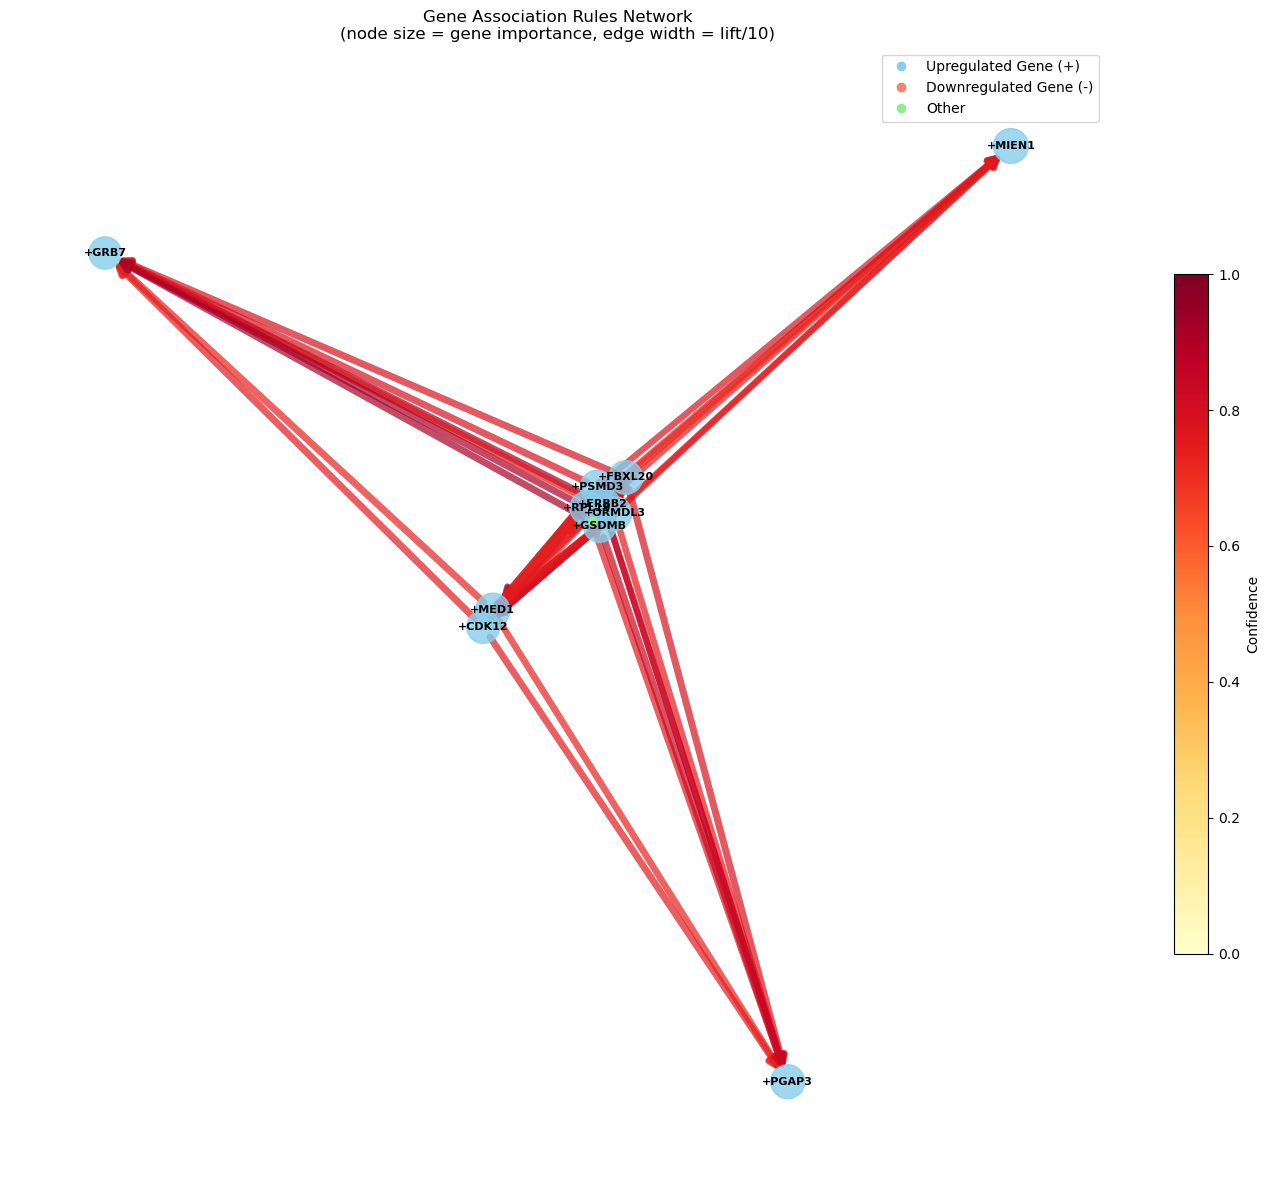

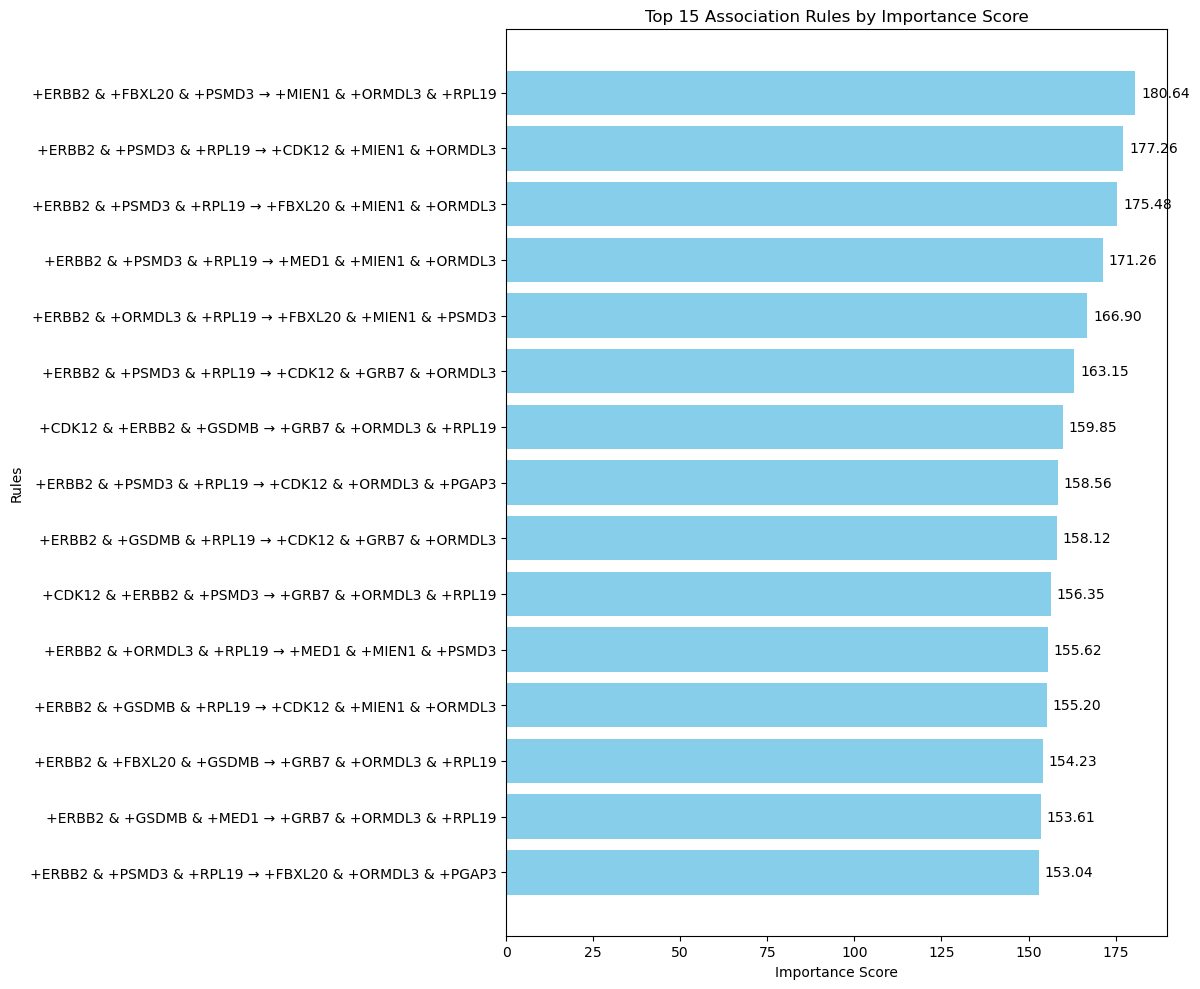

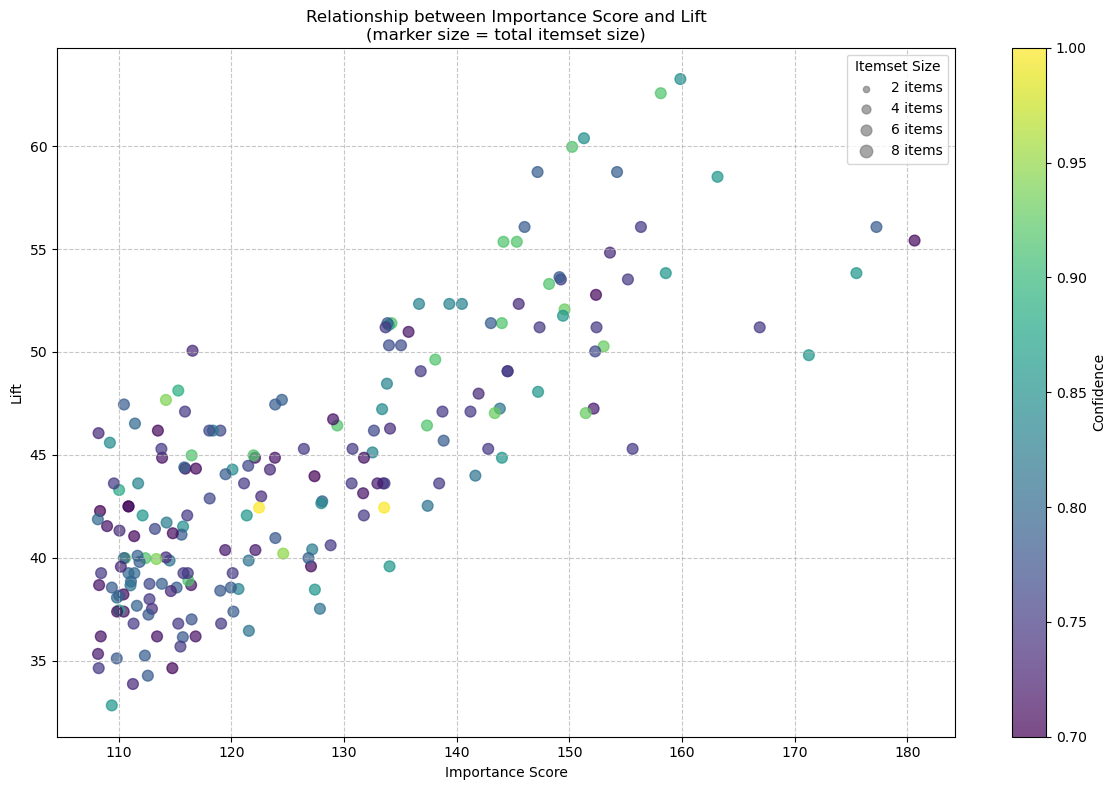

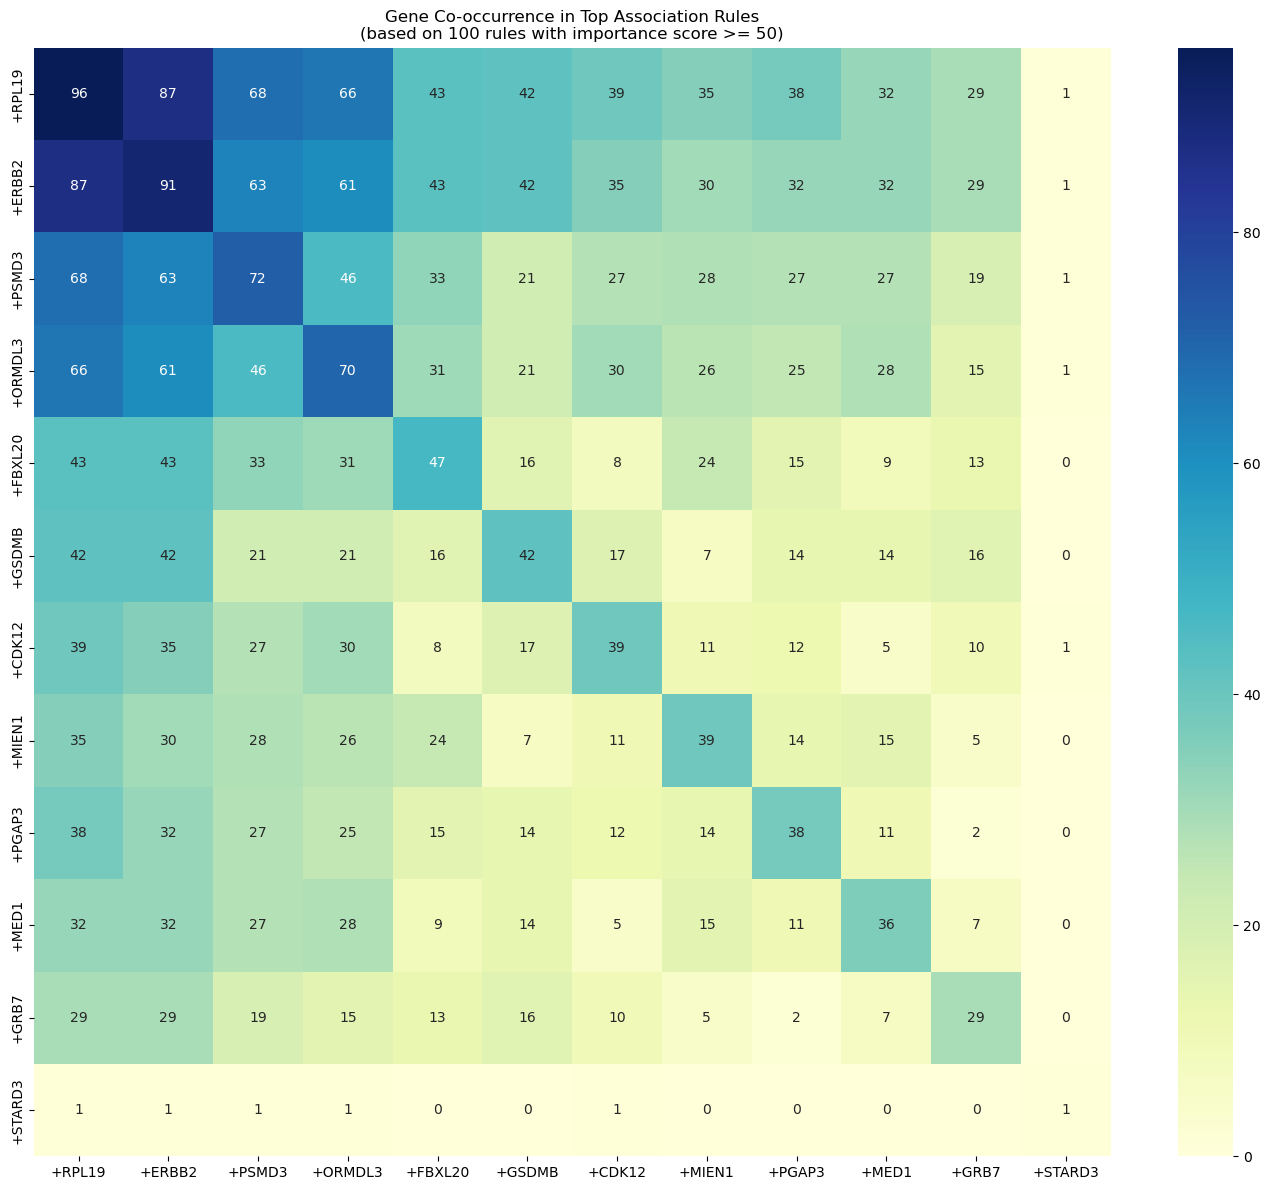

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Enhanced Network visualization for gene association rules
def visualize_gene_rule_network(rules_df, min_importance=50, max_rules=50):
    """
    Create a network visualization of gene association rules
    with node size based on gene importance and edge width based on lift
    """
    # Get top rules by importance score
    top_rules = rules_df.filter(F.col("importance_score") >= min_importance) \
                        .orderBy(F.col("importance_score").desc()) \
                        .limit(max_rules) \
                        .toPandas()

    if len(top_rules) == 0:
        print(f"No rules meet the minimum importance score of {min_importance}. Try a lower threshold.")
        return None

    print(f"Visualizing {len(top_rules)} rules with importance score >= {min_importance}")

    # Create graph
    G = nx.DiGraph()

    # Track node importance for sizing
    node_importance = {}
    node_frequency = {}

    # Add edges from rules
    for _, row in top_rules.iterrows():
        # Process antecedent nodes
        for item_a in row['antecedent']:
            if item_a not in node_importance:
                node_importance[item_a] = 0
                node_frequency[item_a] = 0
            node_importance[item_a] += row['avg_gene_importance']
            node_frequency[item_a] += 1

        # Process consequent nodes
        for item_c in row['consequent']:
            if item_c not in node_importance:
                node_importance[item_c] = 0
                node_frequency[item_c] = 0
            node_importance[item_c] += row['avg_gene_importance']
            node_frequency[item_c] += 1

        # Add edges between all antecedents and consequents
        for item_a in row['antecedent']:
            for item_c in row['consequent']:
                # Add edge with lift and confidence as attributes
                G.add_edge(item_a, item_c,
                           lift=row['lift'],
                           confidence=row['confidence'],
                           importance=row['importance_score'])

    # Calculate average importance for each node
    for node in node_importance:
        node_importance[node] /= max(1, node_frequency[node])

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    if len(G.nodes()) == 0:
        print("No connected nodes in the graph. Try different filtering criteria.")
        return None

    # Set up plot
    plt.figure(figsize=(14, 12))

    # Choose layout based on graph size
    if len(G.nodes()) < 30:
        pos = nx.spring_layout(G, seed=42, k=0.3)
    else:
        pos = nx.kamada_kawai_layout(G)

    # Prepare node sizes based on importance
    node_sizes = [node_importance.get(node, 1) * 200 for node in G.nodes()]

    # Prepare node colors - different for genes with + and - prefixes
    node_colors = []
    for node in G.nodes():
        if node.startswith('+'):
            node_colors.append('skyblue')
        elif node.startswith('-'):
            node_colors.append('salmon')
        else:
            node_colors.append('lightgreen')

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

    # Draw edges with width based on lift and color based on confidence
    edges = G.edges()
    edge_widths = [min(5, G[u][v]['lift'] / 10) for u, v in edges]
    edge_colors = [plt.cm.YlOrRd(G[u][v]['confidence']) for u, v in edges]

    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors,
                          alpha=0.7, arrows=True, arrowsize=15)

    # Draw labels with smaller font for better readability
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Create legend
    plt.plot([0], [0], 'o', color='skyblue', label='Upregulated Gene (+)')
    plt.plot([0], [0], 'o', color='salmon', label='Downregulated Gene (-)')
    plt.plot([0], [0], 'o', color='lightgreen', label='Other')

    # Create a colorbar for confidence
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.6)
    cbar.set_label('Confidence')

    plt.title("Gene Association Rules Network\n(node size = gene importance, edge width = lift/10)")
    plt.axis('off')
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

    return G

# 2. Enhanced Bar chart showing importance score
def plot_top_rules_bar(rules_df, top_n=15, sort_by='importance_score'):
    """
    Create a bar chart of top rules sorted by importance score or other metrics
    """
    # Get top rules
    top_rules = rules_df.orderBy(F.col(sort_by).desc()).limit(top_n).toPandas()

    # Create rule text (truncate if too long)
    def format_rule(row):
        ant = ' & '.join(row['antecedent'][:3])
        if len(row['antecedent']) > 3:
            ant += "..."

        cons = ' & '.join(row['consequent'][:3])
        if len(row['consequent']) > 3:
            cons += "..."

        return f"{ant} → {cons}"

    top_rules['rule_text'] = top_rules.apply(format_rule, axis=1)

    # Plot
    plt.figure(figsize=(12, 10))

    # Sort by the selected metric for display
    top_rules = top_rules.sort_values(sort_by)

    # Create horizontal bar chart
    bars = plt.barh(top_rules['rule_text'], top_rules[sort_by], color='skyblue')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + (width * 0.01), bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', ha='left', va='center')

    plt.xlabel(sort_by.replace('_', ' ').title())
    plt.ylabel('Rules')
    plt.title(f'Top {top_n} Association Rules by {sort_by.replace("_", " ").title()}')
    plt.tight_layout()
    plt.show()

# 3. Scatter plot of importance score vs lift
def plot_importance_lift_scatter(rules_df, min_confidence=0.5, max_rules=200):
    """
    Create a scatter plot showing the relationship between importance score and lift
    """
    # Filter and get data
    scatter_data = rules_df.filter(F.col("confidence") >= min_confidence) \
                          .orderBy(F.col("importance_score").desc()) \
                          .limit(max_rules) \
                          .select("importance_score", "lift", "confidence",
                                  F.size("antecedent").alias("antecedent_size"),
                                  F.size("consequent").alias("consequent_size")) \
                          .toPandas()

    if len(scatter_data) == 0:
        print(f"No rules meet the minimum confidence of {min_confidence}. Try a lower threshold.")
        return

    # Create scatter plot
    plt.figure(figsize=(12, 8))

    # Use confidence for color and total itemset size for marker size
    scatter = plt.scatter(scatter_data['importance_score'],
                          scatter_data['lift'],
                          c=scatter_data['confidence'],
                          s=(scatter_data['antecedent_size'] + scatter_data['consequent_size']) * 10,
                          alpha=0.7, cmap='viridis')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Confidence')

    # Add labels and title
    plt.xlabel('Importance Score')
    plt.ylabel('Lift')
    plt.title('Relationship between Importance Score and Lift\n(marker size = total itemset size)')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add a legend for the marker sizes
    sizes = [2, 4, 6, 8]
    labels = [f'{size} items' for size in sizes]

    # Create dummy scatter points for the legend
    for i, size in enumerate(sizes):
        plt.scatter([], [], s=size*10, c='gray', alpha=0.7, label=labels[i])

    plt.legend(title="Itemset Size", loc='upper right')

    plt.tight_layout()
    plt.show()

# 4. Heatmap of gene co-occurrence
def plot_gene_cooccurrence(rules_df, top_n=20, min_importance=50):
    """
    Create a heatmap showing how frequently genes appear together in rules
    """
    # Get top rules by importance
    top_rules = rules_df.filter(F.col("importance_score") >= min_importance) \
                        .orderBy(F.col("importance_score").desc()) \
                        .limit(100) \
                        .toPandas()

    if len(top_rules) == 0:
        print(f"No rules meet the minimum importance score of {min_importance}. Try a lower threshold.")
        return

    # Collect all unique genes
    all_genes = set()
    for _, row in top_rules.iterrows():
        all_genes.update(row['antecedent'])
        all_genes.update(row['consequent'])

    # Get the most frequent genes
    gene_counts = {}
    for gene in all_genes:
        count = 0
        for _, row in top_rules.iterrows():
            if gene in row['antecedent'] or gene in row['consequent']:
                count += 1
        gene_counts[gene] = count

    # Get top genes
    top_genes = sorted(gene_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_gene_names = [g[0] for g in top_genes]

    # Create co-occurrence matrix
    cooccurrence = np.zeros((len(top_gene_names), len(top_gene_names)))

    for i, gene1 in enumerate(top_gene_names):
        for j, gene2 in enumerate(top_gene_names):
            if i == j:
                cooccurrence[i][j] = gene_counts[gene1]  # Diagonal shows frequency
            else:
                # Count co-occurrences
                count = 0
                for _, row in top_rules.iterrows():
                    all_items = row['antecedent'] + row['consequent']
                    if gene1 in all_items and gene2 in all_items:
                        count += 1
                cooccurrence[i][j] = count

    # Create heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(cooccurrence, annot=True, fmt='g', cmap='YlGnBu',
                xticklabels=top_gene_names, yticklabels=top_gene_names)

    plt.title(f'Gene Co-occurrence in Top Association Rules\n(based on {len(top_rules)} rules with importance score >= {min_importance})')
    plt.tight_layout()
    plt.show()

# Example usage:
# 1. Network visualization of gene associations
G = visualize_gene_rule_network(association_rules_df, min_importance=50)

# 2. Bar chart of top rules by importance score
plot_top_rules_bar(association_rules_df, top_n=15, sort_by='importance_score')

# 3. Scatter plot of importance vs lift
plot_importance_lift_scatter(association_rules_df, min_confidence=0.7)

# 4. Heatmap of gene co-occurrence
plot_gene_cooccurrence(association_rules_df, top_n=20, min_importance=50)